In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

# Ejemplo CAE sobre dataset de MNIST 1

En este notebook se muestra la aplicación de un Autoencoder Convolucional sobre el Dataset de MNIST. 

El Dataset de MNIST es uno de los más utilizados en cursos y formaciones con redes neuronales debido a su sencillez y que no requiere ningún preprocesado de las imágenes. Contiene un total de 60.000 muestras (50k de entrenamiento y 10k de test) etiquetadas de números de un dígito escritos a mano y el tamaño de todas las imágenes es de 28x28 píxeles (784 variables).

El objetivo de la aplicación del CAE será ver si es posible reducir estas 784 variables a un espacio latente mucho menor sin una alta pérdida de información. Posteriomente se aplicarán modelos de ML tanto supervisados como no supervisados para el análisis de la validez de estas variables latentes generadas.

**Librerías**

Básicas

In [4]:
import urllib
import gzip
import pickle
import os
import yaml
from datetime import datetime

Datos

In [5]:
import numpy as np
import pandas as pd

Machine Learning

In [6]:
from keras.callbacks import TensorBoard

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Visualización

In [7]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimage
import seaborn as sns

Propias

In [8]:
from model.cae import CAE
from model import metrics

from utils import plot_paired_imgs
from utils import plot_sample_imgs

In [9]:
def reshape_mnist(vectors):
    images = np.reshape(vectors, (-1,28,28,1))
    return images

## Lectura de datos

Los datos están disponibles online y en un objeto binario serializado que es descargado y leído con _pickle_.

In [10]:
mnistfile = 'mnist.pkl.gz'

if not os.path.isfile(mnistfile):
    url = urllib.request.URLopener()
    url.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", mnistfile)
    
with gzip.open(mnistfile, 'rb') as f:
    training_set, validation_set, testing_set = pickle.load(f, encoding='latin1')

In [11]:
X_train, y_train = training_set
X_test, y_test  = testing_set

Los datos cargados son arrays unidmensionales de 784 valores que son necesarios redimensionar para mostrar las imágenes.

In [12]:
X_train.shape, X_test.shape

((50000, 784), (10000, 784))

In [13]:
X_train = reshape_mnist(X_train)
X_test = reshape_mnist(X_test)

In [14]:
X_train.shape, X_test.shape

((50000, 28, 28, 1), (10000, 28, 28, 1))

Muestra un subset de imágenes. Es relativamente fácil para el ojo humano reconocer cada uno de los dígitos a los que se corresponde. Los vectores Y contienen la etiqueta del dígito representado.

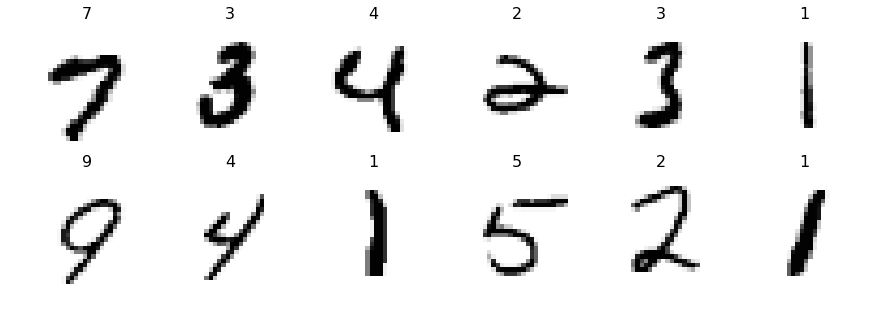

In [69]:
plot_sample_imgs(X_train, 2, 6, color=False, labels=y_train, size=2.5)

## Entrenamiento del Modelo

__Inicializa la arquitectura__

La clase CAE se ha creado para poder añadir un nivel mayor de abstracción sobre Keras cuando se define la arquitectura de un autoencoder convolucional. Los parámetros son los siguientes:


* *input_shape*: dimensiones de entrada. Deberán de ser iguales a las dimensiones de las imágenes que entran, en este caso 28x28x1. La última dimensión es el número de canales, que será 1 para imágenes en blanco y negro y 3 para imágenes a color RGB.

* *latent_features*: dimensiones de la capa oculta de variables latentes, esto, el número de variables a las que queremos comprimir las imágenes.

* *filters*: capas convolucionales, cada elemento de la lista es el número de kernels de la capa convolucional.

* *kernel*: tamaño del kernel.

* *stride*: al número de pixeles que avanza la ventana en cada cálculo de la convolución.

* *pool*: tamaño del pooling para realizar el submuestreo después el la capa de convolución.

* *optimizer*: nombre del optimizador a utilizar.

* *lossfn*: métrica para el cálculo de la función de coste.

* *path*: ruta donde guardar/cargar el CAE entrenado y los parámetros.

* *load*: True/False. Cuando se marca como True se ignoran todos los parámetros de definición de la arquitectura y se carga el CAE que esté almacenado en el *path*.


En este caso se han seleccionado 20 variables latentes en la capa oculta y dos capas convolucionales de 8 y 10 kernels. 

In [16]:
cae = CAE(input_shape=X_train[0].shape, latent_features=20, filters=[8,16], path='/tmp/model')

Instructions for updating:
Colocations handled automatically by placer.


__Entrenamiento__

Para observar los resultados en tiempo real del entrenamiento se utiliza TensorBoard, para ello hay que definir el _callback_ e indicar la ruta donde almacenar el _log_. El servidor de TensorBoard debería estar apuntando a a esta misma ruta.

In [17]:
tb = TensorBoard(log_dir='tmp/logs/mnist' + datetime.now().strftime('%Y%m%d_%H%M'), 
                 write_grads=True, write_images=True, histogram_freq=1)

Es importante darse cuenta que a la hora de entrenar el CAE **la entrada y la salida deben de ser la misma**. Se está intentando reducir codificar una imagen reduciendo el error de reconstrucción al máximo. Se reserva un 10% de los datos de training para validación.

In [ ]:
cae.model.fit(X_train, X_train, epochs=5, callbacks=[tb], validation_split=0.1)

**Guarda el modelo**

El método _save_ guarda el modelo en la ruta indicada. Se guardan 3 ficheros distintos:
* params.yaml: parámetros de la arquitectura.
* encoder.h5: pesos de las capas del encoder.
* decoder.h5: pesos de las capas de decoder.

In [20]:
cae.save()

In [21]:
os.listdir('/tmp/model')

['decoder.h5', 'encoder.h5', 'params.yaml']

In [22]:
with open('/tmp/model/params.yaml') as f:
    params = yaml.load(f)
    
params

{'filters': [8, 16],
 'input_shape': (28, 28, 1),
 'kernel': (3, 3),
 'latent_features': 20,
 'lossfn': 'mse',
 'optimizer': 'adamax',
 'pool': (2, 2),
 'stride': 1}

Es posible cargar el modelo entrenado únicamente indicando el path donde está guardado.

In [23]:
cae = CAE(path='/tmp/model', load=True)

## Análisis de la salida

Además de la abstracción sobre la definición de la arquitectura en Keras la clase CAE incluye también como atributos, además del CAE entrenado al completo, el encoder y el decoder como modelos independientes. De esta forma es muy sencillo realizar la codificación y la decodificación de imágenes llamando al método *predict* de estos objetos.

In [24]:
cae.model, cae.encoder, cae.decoder

(<keras.engine.training.Model at 0x1c3de1a5c0>,
 <keras.engine.sequential.Sequential at 0x1c3dec5048>)

**Pérdida de reconstrucción**

Se puede evaluar la pérdida de reconstrucción de la imágene calculando el error cuadrátrico medio entre la imagen original y la reconstruida. 

In [25]:
cae.model.evaluate(X_train, X_train)

50000/50000 [==============================] - 5s 93us/step


0.01178719367802143

In [26]:
cae.model.evaluate(X_test, X_test)

10000/10000 [==============================] - 1s 97us/step


0.011510138456523418

En train y test son muy similares por lo que se concluye que no hay overfitting.

__Muestra de imágenes reconstruidas__

Con la llamada al método predict el objeto model se obtienen los arrays de las imágenes reconstruidas.

In [27]:
X_train_pred = cae.model.predict(X_train)
X_test_pred = cae.model.predict(X_test)

Las imágenes reconstruidas son muy similares a las originales tanto en el conjunto de train como en el de test.

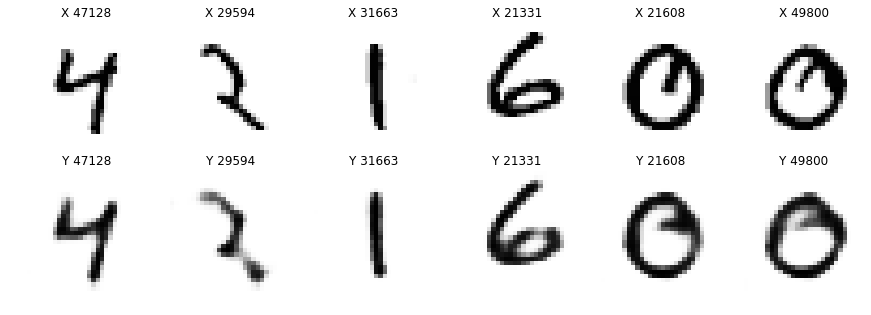

In [30]:
plot_paired_imgs(X_train, X_train_pred, N=6, orient='h', color=False, size=2.5)

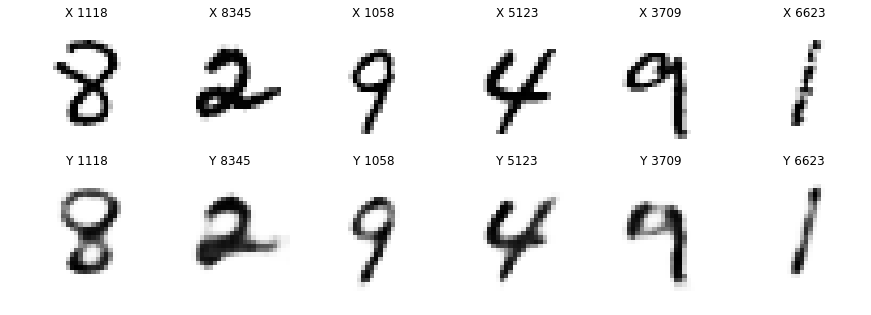

In [38]:
plot_paired_imgs(X_test, X_test_pred, N=6, orient='h', color=False, size=2.5)

**Obtención de variables latentes**

Llamando al método *predict* del encoder se obtendrán los valores de las 20 variables generadas para cada imágen.

In [31]:
X_train_enc = cae.encoder.predict(X_train)
X_test_enc = cae.encoder.predict(X_test)

In [32]:
X_train_enc.shape, X_test_enc.shape

((50000, 20), (10000, 20))

__Modelo Supervisado__

Una de las opciones para analizar la calidad de las variables generadas, además de la pérdida de reconstrucción, es utilizar estas variables como entrada a otros modelos. Por ejemplo en este caso se va a utilizar una Regresión Logística sobre estas variables para predecir el dígito. Es importante notar que debido a la alta dimensionalidad no hubiera sido posible o se hubieran obtenido unos resultados muy pobres utilzando las 784 variables originales como entrada del modelo.

In [36]:
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=200)

In [37]:
lr.fit(X_train_enc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
y_train_pred = lr.predict(X_train_enc)
y_test_pred = lr.predict(X_test_enc)

Los resultados del modelo son bastante buenos, con un *accurary* medio del 90% en el conjunto de test.

In [41]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      4932
           1       0.95      0.97      0.96      5678
           2       0.87      0.86      0.87      4968
           3       0.87      0.86      0.87      5101
           4       0.90      0.88      0.89      4859
           5       0.83      0.83      0.83      4506
           6       0.91      0.94      0.92      4951
           7       0.90      0.92      0.91      5175
           8       0.86      0.83      0.84      4842
           9       0.85      0.83      0.84      4988

   micro avg       0.89      0.89      0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000



In [42]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.89      0.86      0.88      1032
           3       0.88      0.89      0.88      1010
           4       0.92      0.91      0.91       982
           5       0.86      0.84      0.85       892
           6       0.91      0.92      0.91       958
           7       0.92      0.91      0.91      1028
           8       0.86      0.87      0.86       974
           9       0.87      0.85      0.86      1009

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Mediante la matriz de confusión se puede identificar en qué números se ha cometido más error. Por ejemplo, como era de esperar, los errores en el 4 suelen ser predichos como 9.

Text(83.94, 0.5, 'Prediction')

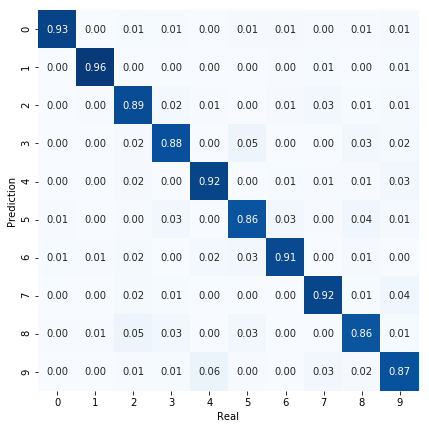

In [43]:
plt.figure(figsize=(8,7))

sns.heatmap(pd.crosstab(y_test_pred, y_test, normalize='index'), 
            cmap='Blues', annot=True, fmt='.2f', square=True, vmax=1, vmin=0, cbar=False)

plt.xlabel('Real')
plt.ylabel('Prediction')

**Reducción de dimensionalidad**

La gran mayoría de algoritmos de reducción de dimensionalidad como PCA y especialmente tSNE no admiten un número de variables tan alto como las 784 iniciales que se tenían. En este caso se va a utilizar la salida codificada como entrada a los algoritmos de reducción de dimensionalidad para realizar una representación bidimensional de la distribución de los dígitos.

__PCA__

Con el algoritmo de PCA se hace una reducción identificando las componentes principales mediante combinaciones lineales de las otras variables. Para representar los dígitos en 2 dimensiones se obienen las dos primeras componentes.

In [118]:
pca = PCA(n_components=2)

In [119]:
X_train_enc_pca = pca.fit_transform(X_train_enc)

Con las dos primeras componentes se representas el 39% de la varianza de los datos. No se espera ver grandes resultados en la representación 2D debido a que gran parte de la varianza queda fuera.

In [122]:
pca.explained_variance_ratio_

array([0.24032657, 0.1349783 ], dtype=float32)

In [120]:
X_train_enc_pca[:,1]

array([ 0.6406583 , -0.24814816,  0.6898029 , ..., -2.3894398 ,
       -0.5899435 , -0.08575194], dtype=float32)

Aún asi se puede ver como con la primera componente se diferencian claramente los 1s contra el resto de números.

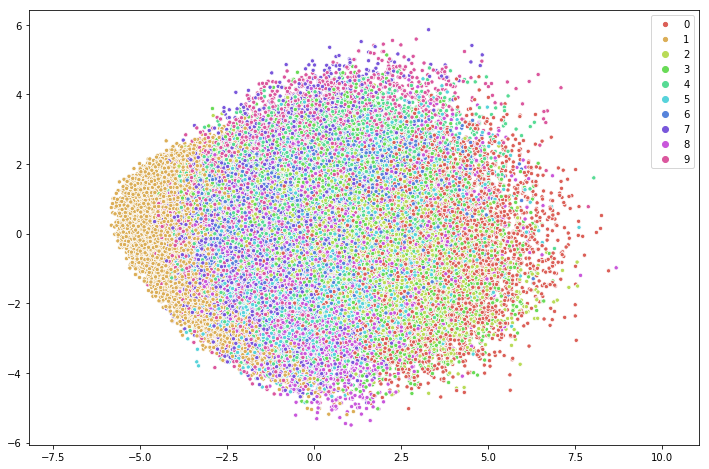

In [72]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_train_enc_pca[:,0], y=X_train_enc_pca[:,1], hue=y_train, size=1,
                palette=sns.color_palette("hls", 10))
plt.axis('equal')
pass

__tSNE__

Este algoritmo está diseñado especialemente para visualización el 2 o 3 dimensiones de conjuntos de datos y se obverva que los resultados de la agrupación son mucho mejores que PCA.

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_train_enc_tsne = tsne.fit_transform(X_train_enc)

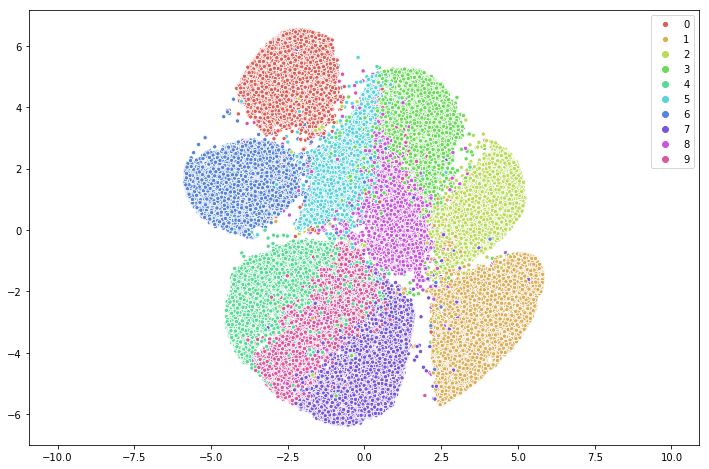

In [57]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_train_enc_tsne[:,0], y=X_train_enc_tsne[:,1], hue=y_train, size=1,
                palette=sns.color_palette("hls", 10))
plt.axis('equal')
pass

__Clustering: KMeans__

Por último se evaluan los resultados sobre un modelo no supervisado. Este caso es una simulación mejor el caso de las imágenes histológicas ya que de estas se tienen etiquetas a nivel imagen completa pero no a nivel *patch*.

La idea detrás de este proceso es que, mediante un algoritmo de clustering, se agrupen las distintas imágenes según su forma. Si el resultado de el clustering es bueno cada grupo deberá tener un tipo de etiqueta (dígito en ese caso) predominante.

Para esto se utilizará un KMeans sobre la salida bidimensonal del TSNE para agilizar el entrenamiento y mejorar los resultados. 

In [58]:
K = 20
kmeans = KMeans(n_clusters=K)

In [59]:
y_train_clust = kmeans.fit_predict(X_train_enc_tsne)

La siguiente imagen muestra el porcentaje de cada dígito en cada grupo generado.

In [60]:
freq_table = pd.crosstab(y_train, y_train_clust, rownames='N', colnames='C', normalize='columns')

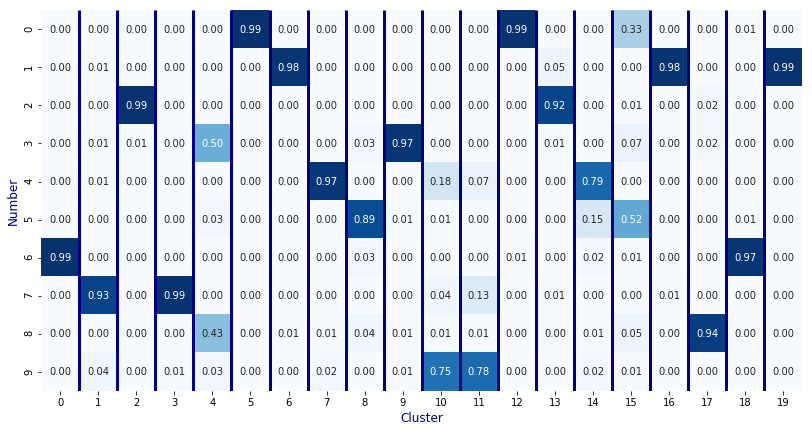

In [61]:
plt.figure(figsize=(14,7))

sns.heatmap(freq_table, cmap='Blues', square=True, 
           annot=True, fmt='.2f', vmax=1, vmin=0, cbar=False)

plt.xlabel('Cluster', fontsize=12, color='navy')
plt.ylabel('Number', fontsize=12, color='navy')

plt.vlines(list(range(1, K)) ,0, 10, lw=3, color='navy')

Una manera de evaluar esta agrupación, ya que se tienen todas las muestras debidamente etiquetadas, es utilizar métricas de impureza como GINI o la entropía. Los cluster con menor GINI serán aquellos donde haya menos ruido de otros dígitos. El clúster 4, es el es que mayor GINI tiene, era de esperar ya que su dígito más contenido representa únicamente el 50% de las muestras.

Otro dato interesante sería la diferencia entre el grupo 10 y el 11, ambos tienen un porcentaje alto de dígitos 9s pero mientras en uno el siguiente más representado es el 4 otro es el 7. Se se observan las muestras de imágenes se ve que el cluster 11 tiene aquellos 9s en los que el palo está inclinado, es decir, similar al del número 7. Similar al caso de los grupos 16 y 19, con 1s inclinados y rectos.

Esto prueba que, no sólo ha sido posible separar automáticamente según el dígito si no que se han separado también según su forma de escritura.

In [62]:
ginis = metrics.cluster_gini(y_train_clust, y_train)

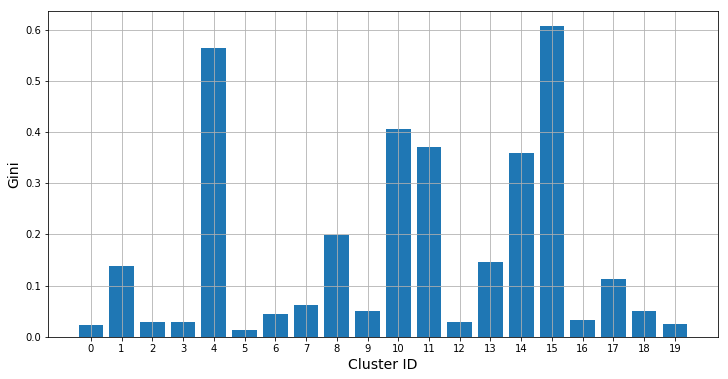

In [63]:
plt.figure(figsize=(12,6))

plt.bar(ginis.keys(), ginis.values())
plt.xticks(list(ginis.keys()))

plt.xlabel('Cluster ID', fontsize=14)
plt.ylabel('Gini', fontsize=14)

plt.grid()
pass

Por último se muestran unas pocas imágenes de cada clúster para comprobar que tienen sentido.

 Cluster 0


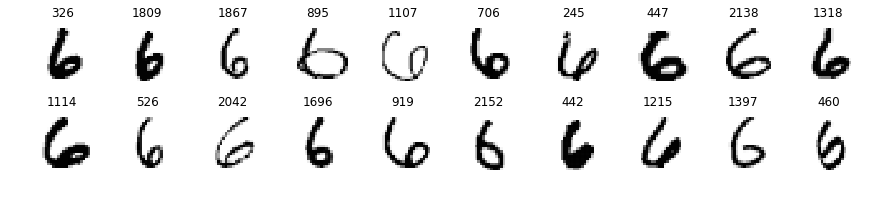

 Cluster 1


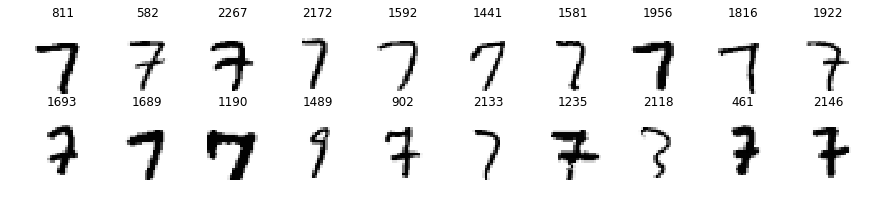

 Cluster 2


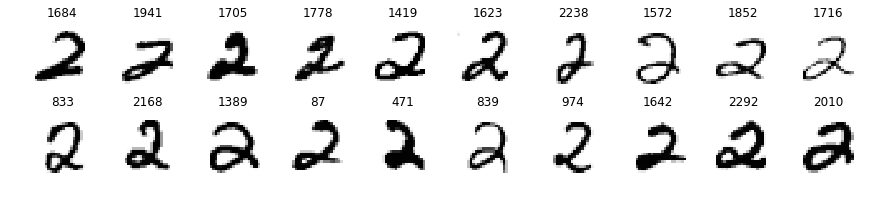

 Cluster 3


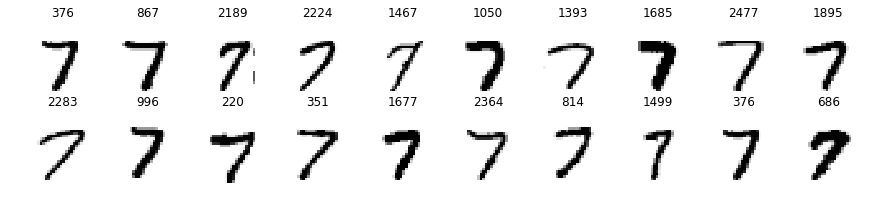

 Cluster 4


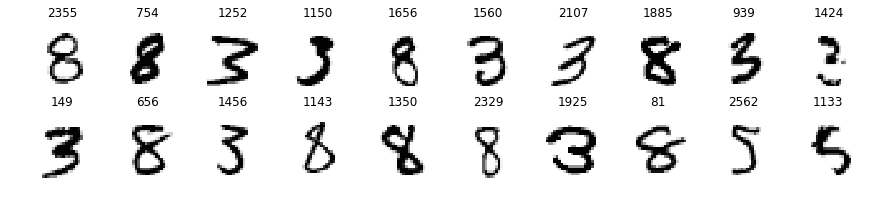

 Cluster 5


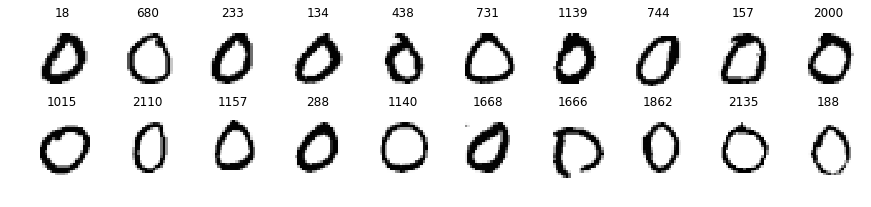

 Cluster 6


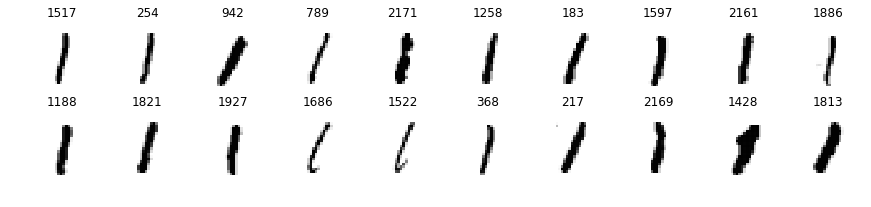

 Cluster 7


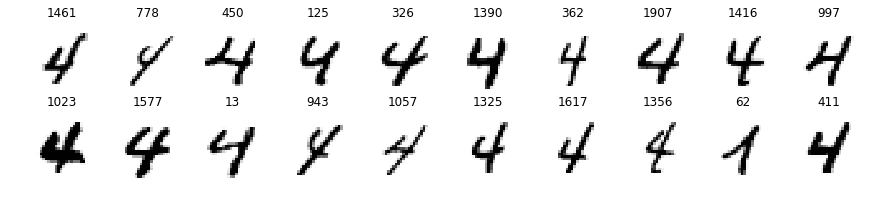

 Cluster 8


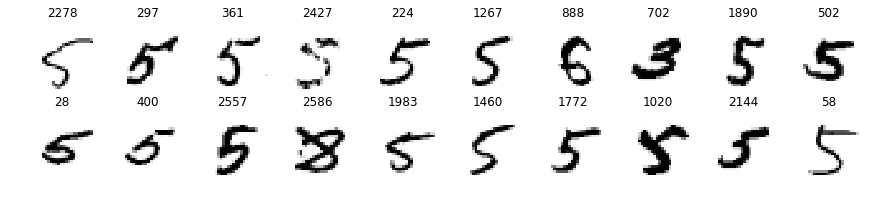

 Cluster 9


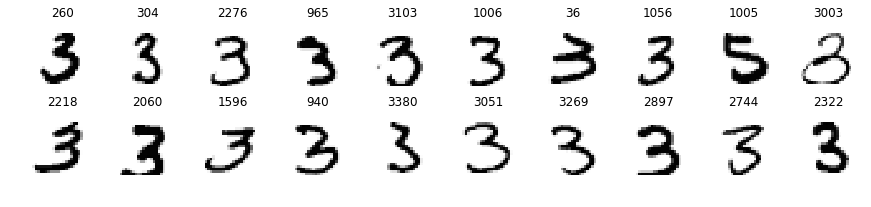

 Cluster 10


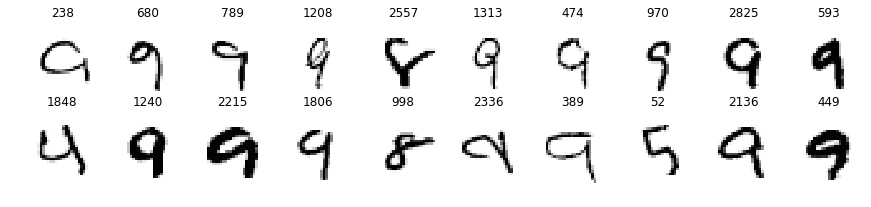

 Cluster 11


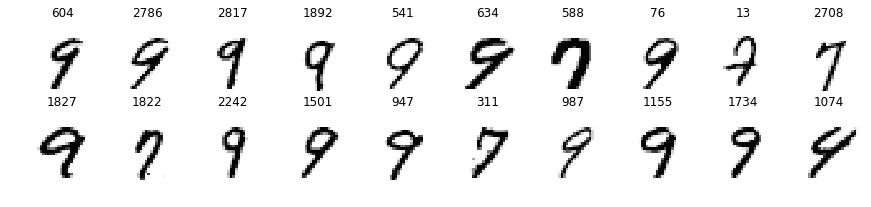

 Cluster 12


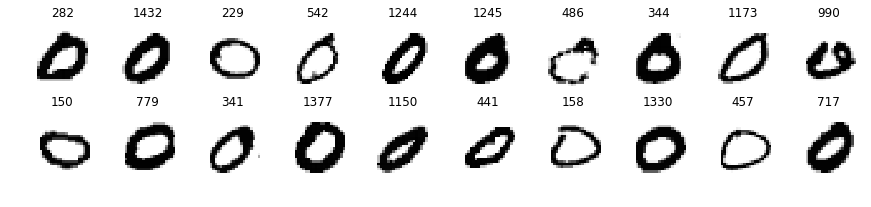

 Cluster 13


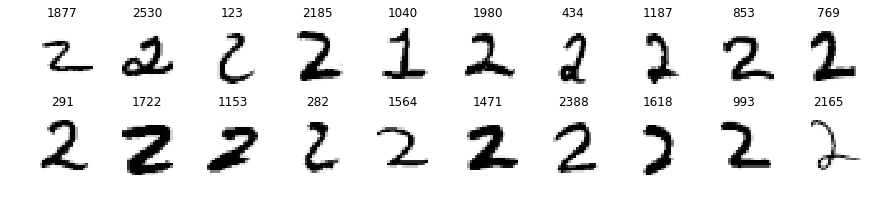

 Cluster 14


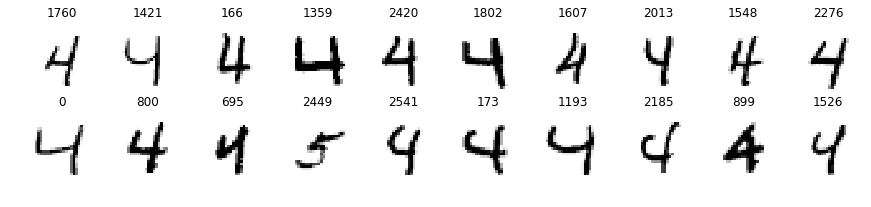

 Cluster 15


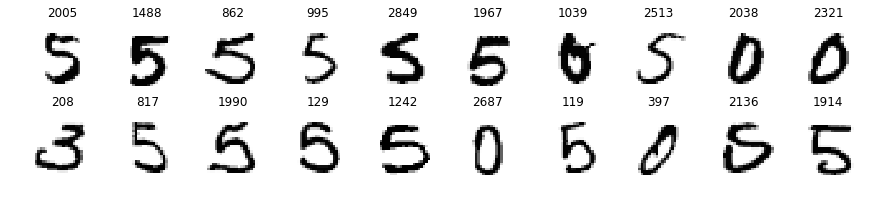

 Cluster 16


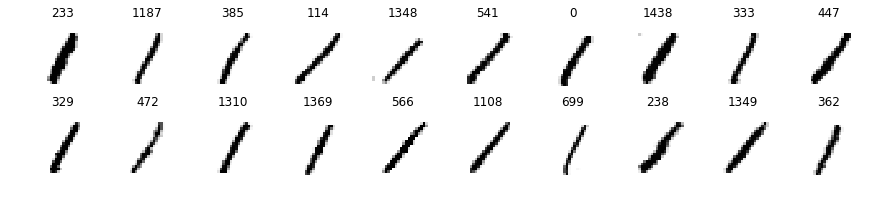

 Cluster 17


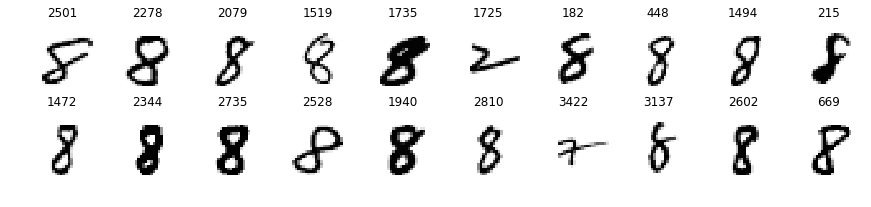

 Cluster 18


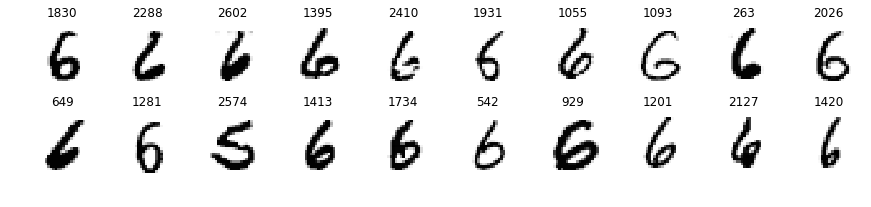

 Cluster 19


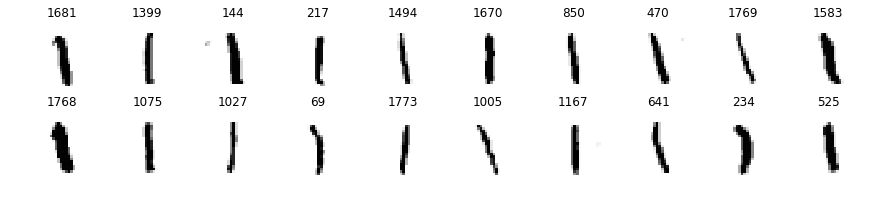

In [67]:
for cluster in range(K):
    print('\033[1m Cluster {}'.format(cluster))
    plot_sample_imgs(X_train[y_train_clust == cluster], n_rows=2, n_cols=10, size=1.5, color=False)
    plt.show()